In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [4]:
dist = 20
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [5]:
xvals = np.linspace(-20, 100, 1000)
xvals_r = xvals.reshape(1000, 1)

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


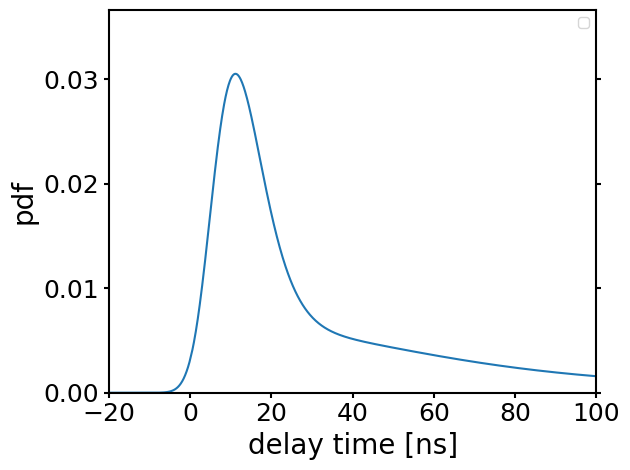

In [7]:
probs = c_multi_gamma_prob(xvals_r, mix_probs, gamma_a, gamma_b, 3.0, 0.1)

fig, ax = plt.subplots()
plt.plot(xvals, probs)
plot_args = {'xlim':[-20, 100],
                     'ylim':[0.0, 1.2 * np.amax(probs)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [8]:
c_multi_gamma_sf_v1d = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

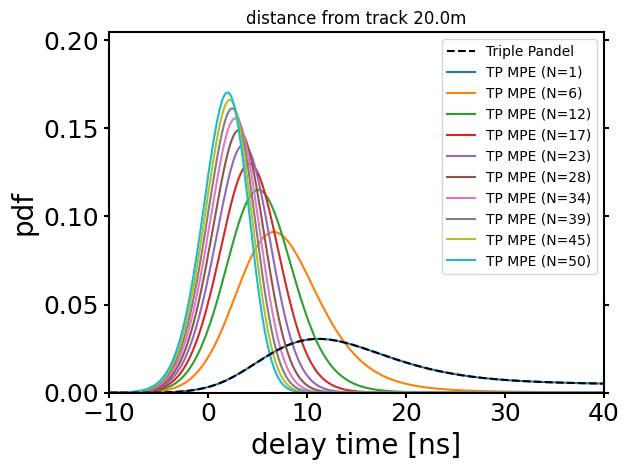

In [9]:
sfs = c_multi_gamma_sf_v1d(xvals, mix_probs, gamma_a, gamma_b, 3.0)

fig, ax = plt.subplots()
plt.plot(xvals, probs,linestyle='dashed', color='black', zorder=100, label='Triple Pandel')

y_max = np.amax(probs)
n_photons = jnp.array(np.linspace(1, 50, 10))
for n_p in n_photons:
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})')
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 40],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [11]:
# test gradient

c_gamma_sf_grad = jax.grad(c_gamma_sf, argnums=(1,2))

In [31]:
for i in range(3):
    print(c_gamma_sf(20.0, gamma_a[i], gamma_b[i], 3.0))

0.8154121648356085
0.15162732268154114
0.9502130376826033


In [30]:
for i in range(3):
    print(c_gamma_sf_grad(20.0, gamma_a[i], gamma_b[i], 3.0))

(Array(0.23130632, dtype=float64), Array(-7.15754617, dtype=float64))
(Array(0.10207543, dtype=float64), Array(-1.53986809, dtype=float64))
(Array(0.16294393, dtype=float64), Array(-16.90162604, dtype=float64))


In [33]:
def log_c_gamma_mpe(x, a, b, sigma, n_photons):
    prob = c_gamma_prob(x, a, b, sigma=sigma, delta=0.1)
    sf = c_gamma_sf(x, a, b, sigma=3.0)
    #ys = n_p * probs * sfs**(n_p-1)
    return jnp.log(n_photons) + jnp.log(prob) + (n_photons-1) * jnp.log(sf)

log_c_gamma_mpe_grad = jax.grad(log_c_gamma_mpe, argnums=(1,2))

In [44]:
x = 100.0
n_p = 100

for i in range(3):
    print("fn:", log_c_gamma_mpe(x, gamma_a[i], gamma_b[i], 3.0, n_p))

for i in range(3):
    print("grad:", log_c_gamma_mpe_grad(x, gamma_a[i], gamma_b[i], 3.0, n_p))

fn: -227.73150918476722
fn: -2417.289155669201
fn: -28.51187839886942
grad: (Array(118.01865016, dtype=float64), Array(-7912.78301116, dtype=float64))
grad: (Array(223.64640521, dtype=float64), Array(-9520.0574763, dtype=float64))
grad: (Array(52.9765788, dtype=float64), Array(-9086.10088802, dtype=float64))
